<a href="https://colab.research.google.com/github/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/blob/main/notebooks/01_ARIMA_SARIMA_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Entrenamiento, Predicción y Evaluación de los modelos Arima y Sarima

#### **Entrenamiento**

In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from datetime import datetime
from io import BytesIO

DATA_GITHUB_URL = 'https://raw.githubusercontent.com/DCajiao/Time-series-forecast-of-energy-consumption-in-Tetouan-City/refs/heads/main/data/zone1_power_consumption_of_tetouan_city.csv'

# Descargar los datos desde github
response = requests.get(DATA_GITHUB_URL)

# Convertir en un df desde el xlsx de github
df = pd.read_csv(BytesIO(response.content), sep=',')

In [ ]:
# Mostrar información del subset
print("Información del dataset:")
print(df.info())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datetime               52416 non-null  object 
 1   temperature            52416 non-null  float64
 2   humidity               52416 non-null  float64
 3   wind_speed             52416 non-null  float64
 4   general_diffuse_flows  52416 non-null  float64
 5   zone_1                 52416 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB
None


In [ ]:
df_zone1 = df

Extracción de características (como la estacionariedad).

In [ ]:
print("\n=== Test de Dickey-Fuller Aumentado (Serie Original) ===")
result_adf = adfuller(serie.dropna())
print(f'ADF Statistic: {result_adf[0]:.4f}')
print(f'p-value: {result_adf[1]:.10f}')
print('Valores críticos:')
for key, value in result_adf[4].items():
    print(f'\t{key}: {value:.3f}')


=== Test de Dickey-Fuller Aumentado (Serie Original) ===
ADF Statistic: -32.1213
p-value: 0.0000000000
Valores críticos:
	1%: -3.430
	5%: -2.862
	10%: -2.567


### ANÁLISIS SOBRE LA SELECCIÓN DE HIPERPARÁMETROS

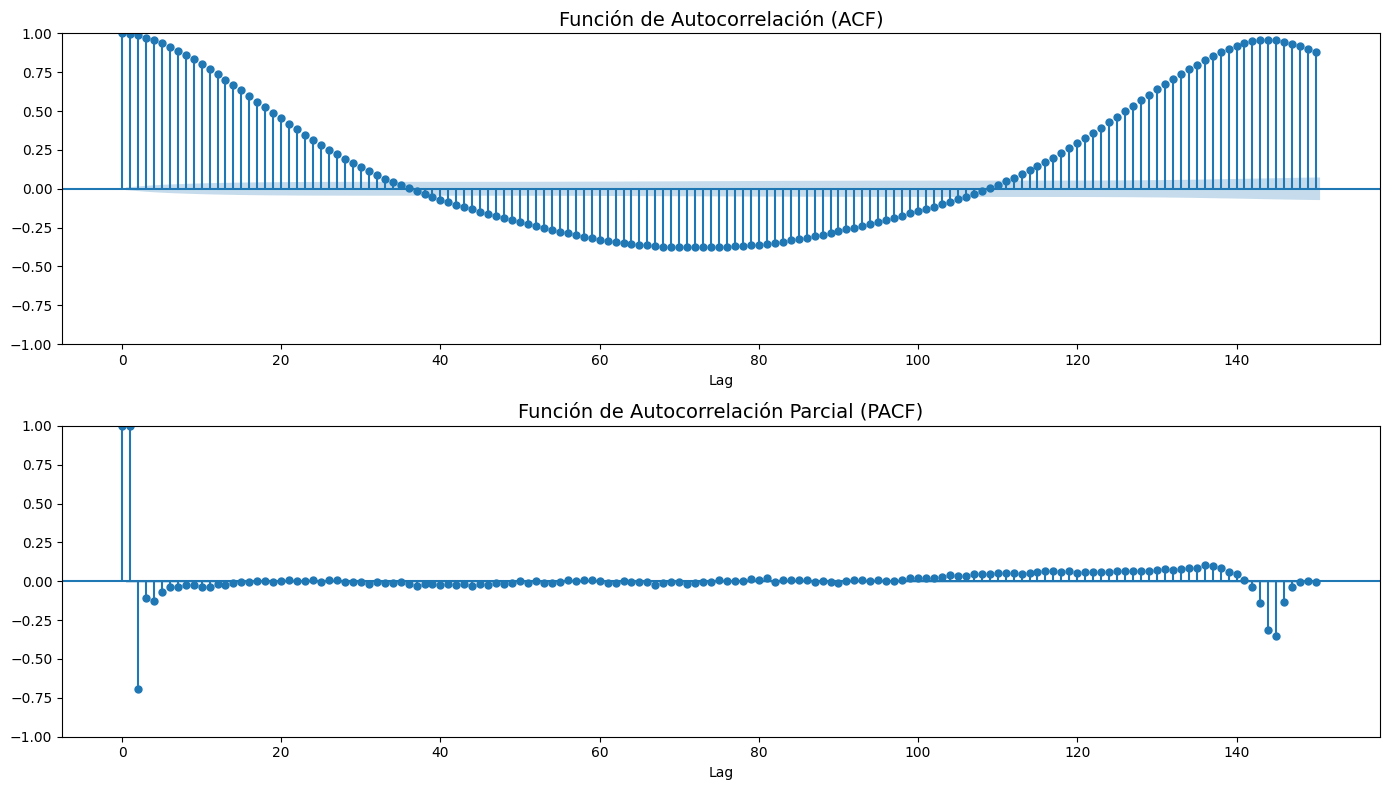

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# ACF
plot_acf(serie.dropna(), lags=150, ax=ax1)
ax1.set_title('Función de Autocorrelación (ACF)', fontsize=14)
ax1.set_xlabel('Lag')

# PACF
plot_pacf(serie.dropna(), lags=150, ax=ax2)
ax2.set_title('Función de Autocorrelación Parcial (PACF)', fontsize=14)
ax2.set_xlabel('Lag')

plt.tight_layout()
plt.show()

Inicialmente, se tiene que el test de Dickey-Fuller arrojó un p-valor = 0.000, por lo que la serie es estacionaria y no se debe diferenciar, d = 0. La componente p de número de términos autorregresivos se puede encontrar a partir de la gráfica de autocorrelación parcial. Se pueden ver picos más significativos en el lag 1 y 2, seguido de un corte abrupto. Esto indica un p = 1 o 2. La ACF no presenta un corte abrupto sino un decaimiento oscilatorio que cruza rápidamente las bandas de confianza, sugiriendo que q=0, aunque podría considerarse q=1 para capturar pequeños efectos de media móvil.

---

#### **Predicción**

### MODELO ARIMA

In [ ]:
def smape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
  return np.mean(np.abs(y_true - y_pred) / denominator) * 100

def wape(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

A un paso

In [ ]:
# Usar últimos 7 días
n_dias = 7
n_observaciones = n_dias * 24 * 6  # 7 días * 24h * 6 intervalos = 1008 observaciones

In [ ]:
# PREDICCIÓN A UN PASO (10 minutos adelante)

# Seleccionar datos recientes
serie_reciente = serie.tail(n_observaciones)
variable_exogena = df_zone1['temperature'].tail(n_observaciones)

# División train/test (80/20)
split_point = int(len(serie_reciente) * 0.8)
train_serie = serie_reciente[:split_point]
test_serie = serie_reciente[split_point:]
train_exog = variable_exogena[:split_point].to_frame()
test_exog  = variable_exogena[split_point:].to_frame()

print("=== CONFIGURACIÓN PARA PREDICCIÓN A UN PASO (10 minutos) ===")
print(f"Total observaciones: {len(serie_reciente)}")
print(f"Train: {len(train_serie)} observaciones ({len(train_serie)/6:.1f} horas)")
print(f"Test: {len(test_serie)} observaciones ({len(test_serie)/6:.1f} horas)")
print(f"Horizonte de predicción: 1 paso (10 minutos)")


=== CONFIGURACIÓN PARA PREDICCIÓN A UN PASO (10 minutos) ===
Total observaciones: 1008
Train: 806 observaciones (134.3 horas)
Test: 202 observaciones (33.7 horas)
Horizonte de predicción: 1 paso (10 minutos)


In [ ]:
import time
start_time = time.time()

p, d, q = 2, 0, 0
print(f"\n=== ENTRENANDO MODELO ARIMA({p},{d},{q}) ===")

modelo_arima = ARIMA(train_serie, order=(p, d, q))
resultado_arima = modelo_arima.fit()

print(f"AIC: {resultado_arima.aic:.2f}")
print(f"BIC: {resultado_arima.bic:.2f}")

train_time_arima = time.time() - start_time
print(f"Tiempo de entrenamiento: {train_time_arima:.2f} segundos")



=== ENTRENANDO MODELO ARIMA(2,0,0) ===
AIC: 11801.44
BIC: 11820.21
Tiempo de entrenamiento: 0.30 segundos


In [ ]:
print("\n=== ARIMA - PRONÓSTICO A UN PASO (One-step ahead) ===")

# get_prediction = usa valores reales para cada paso
pred_arima_one_step = resultado_arima.get_prediction(
    start=test_serie.index[0],
    end=test_serie.index[-1],
    dynamic=False
)

pred_arima_one_step_mean = pred_arima_one_step.predicted_mean

# Evaluamos sobre todo el test
smape_arima_1step = smape(test_serie, pred_arima_one_step_mean)
wape_arima_1step  = wape(test_serie, pred_arima_one_step_mean)

print(f"sMAPE: {smape_arima_1step:.2f}%")
print(f"WAPE : {wape_arima_1step:.2f}%")


=== ARIMA - PRONÓSTICO A UN PASO (One-step ahead) ===
sMAPE: 17.26%
WAPE : 16.82%


A múltiples pasos

In [ ]:
print("\n=== ARIMA - PRONÓSTICO MULTI-STEP ===")

n_pasos_futuro = 18   # 3 horas adelante
pred_arima_multi = resultado_arima.get_forecast(steps=n_pasos_futuro)

pred_arima_multi_mean = pred_arima_multi.predicted_mean
pred_arima_multi_mean.index = test_serie.index[:n_pasos_futuro]

smape_arima_multi = smape(test_serie.iloc[:n_pasos_futuro], pred_arima_multi_mean)
wape_arima_multi  = wape(test_serie.iloc[:n_pasos_futuro], pred_arima_multi_mean)

print(f"sMAPE (3h): {smape_arima_multi:.2f}%")
print(f"WAPE  (3h): {wape_arima_multi:.2f}%")


=== ARIMA - PRONÓSTICO MULTI-STEP ===
sMAPE (3h): 1.09%
WAPE  (3h): 1.09%


---

### MODELO SARIMAX


La serie temporal presenta una estacionalidad diaria extremadamente marcada, evidenciada por el comportamiento casi sinusoidal de la ACF con un pico dominante cerca del lag 144 (equivalente a 24 horas con mediciones cada 10 minutos), sugiriendo la presencia de una raíz unitaria estacional que requiere diferenciación estacional (D=1). La PACF revela un spike significativo en los lags iniciales y múltiples picos negativos alrededor del lag 144, patrón característico que indica que, tras aplicar la diferenciación estacional, un término de media móvil estacional captura eficientemente la dependencia temporal, siendo Q=1 la mejor elección. Considerando que el modelo base ya incorpora order=(2,0,0), la configuración estacional óptima sería seasonal_order=(0,1,1,144) como punto de partida, dado que es la parametrización más habitual cuando la ACF estacional domina el comportamiento de la serie.

In [ ]:
# Parámetros SARIMAX con estacionalidad diaria
order = (2, 0, 0)
seasonal_order = (0, 1, 1, 144)  # 144 = 24 horas * 6 intervalos

In [ ]:
print(f"\n=== MODELO SARIMAX  ===")

start_time = time.time()
try:
    modelo_sarimax = SARIMAX(
        train_serie,
        exog=train_exog,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultado_sarimax = modelo_sarimax.fit(disp=False)

    train_time_sarimax = time.time() - start_time
    print(f"Tiempo de entrenamiento: {train_time_sarimax:.2f} segundos")

except Exception as e:
    print(f"Error en el entrenamiento SARIMAX: {e}")



=== MODELO SARIMAX  ===
Tiempo de entrenamiento: 1097.35 segundos


In [ ]:
print("\n=== SARIMAX - PREDICCIÓN A UN PASO (One-step ahead) ===")

pred_sarimax_1 = resultado_sarimax.get_prediction(
    start=len(train_serie),
    end=len(train_serie) + len(test_serie) - 1,
    exog=test_exog,
    dynamic=False
)

pred_sarimax_1_mean = pred_sarimax_1.predicted_mean

smape_sarimax_1 = smape(test_serie, pred_sarimax_1_mean)
wape_sarimax_1  = wape(test_serie, pred_sarimax_1_mean)

print(f"sMAPE: {smape_sarimax_1:.2f}%")
print(f"WAPE : {wape_sarimax_1:.2f}%")


=== SARIMAX - PREDICCIÓN A UN PASO (One-step ahead) ===
sMAPE: 3.85%
WAPE : 3.99%


In [ ]:
print("\n=== SARIMAX - PRONÓSTICO MULTI-STEP (3h adelante) ===")

pred_sarimax_multi = resultado_sarimax.get_forecast(
    steps=n_pasos_futuro,
    exog=test_exog.iloc[:n_pasos_futuro]
)

pred_sarimax_multi_mean = pred_sarimax_multi.predicted_mean
pred_sarimax_multi_mean.index = test_serie.index[:n_pasos_futuro]

smape_sarimax_multi = smape(test_serie.iloc[:n_pasos_futuro], pred_sarimax_multi_mean)
wape_sarimax_multi  = wape(test_serie.iloc[:n_pasos_futuro], pred_sarimax_multi_mean)

print(f"sMAPE (3h): {smape_sarimax_multi:.2f}%")
print(f"WAPE  (3h): {wape_sarimax_multi:.2f}%")


=== SARIMAX - PRONÓSTICO MULTI-STEP (3h adelante) ===
sMAPE (3h): 1.41%
WAPE  (3h): 1.44%


#### **Analisis de resultados**

### PRONÓSTICO A UN PASO MODELOS ARIMA Y SARIMAX

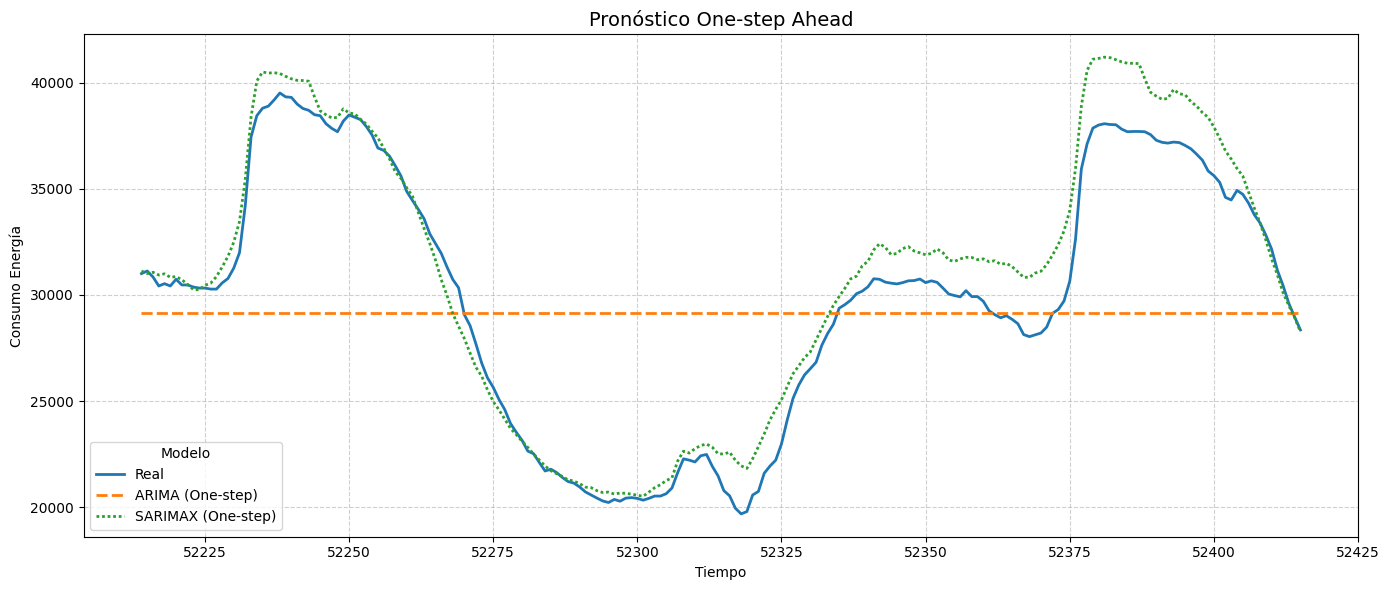

In [ ]:
# Armar dataframe con predicciones one-step
df_one_step = pd.DataFrame({
    "time": test_serie.index,
    "Real": test_serie.values,
    "ARIMA (One-step)": pred_arima_one_step_mean.values,
    "SARIMAX (One-step)": pred_sarimax_1_mean.values
})

# Convertir a formato largo (tidy)
df_one_step_long = df_one_step.melt(id_vars="time",
                                    value_vars=["Real", "ARIMA (One-step)", "SARIMAX (One-step)"],
                                    var_name="Modelo", value_name="Consumo")

# Gráfico con seaborn
plt.figure(figsize=(14,6))
sns.lineplot(data=df_one_step_long, x="time", y="Consumo", hue="Modelo", style="Modelo", linewidth=2)

plt.title("Pronóstico One-step Ahead", fontsize=14)
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

En la gráfica del pronóstico One-step Ahead se observa un contraste marcado entre los dos modelos. El ARIMA, representado por la línea naranja, se mantiene prácticamente constante alrededor de un valor promedio en torno a 29,000, lo cual refleja su incapacidad para capturar la fuerte estacionalidad diaria y las variaciones rápidas del consumo energético. En este contexto funciona apenas como un modelo base o de referencia En cambio, el SARIMAX, mostrado en verde, logra seguir de manera mucho más realista la serie original: reproduce las subidas bruscas en horas de mayor demanda, así como las caídas nocturnas, aunque en algunos puntos tienda a sobreestimar los picos o subestimar ciertos valles. Esto demuestra que, en un escenario con mediciones de alta frecuencia y fuerte patrón estacional, un modelo ARIMA puro resulta insuficiente, mientras que SARIMAX, al incorporar diferenciación estacional y variables exógenas (como la temperatura), ofrece un ajuste considerablemente más preciso y ajustado a la dinámica real del consumo eléctrico.



### PRONÓSTICO A MÚLTIPLES PASOS MODELOS ARIMA Y SARIMAX

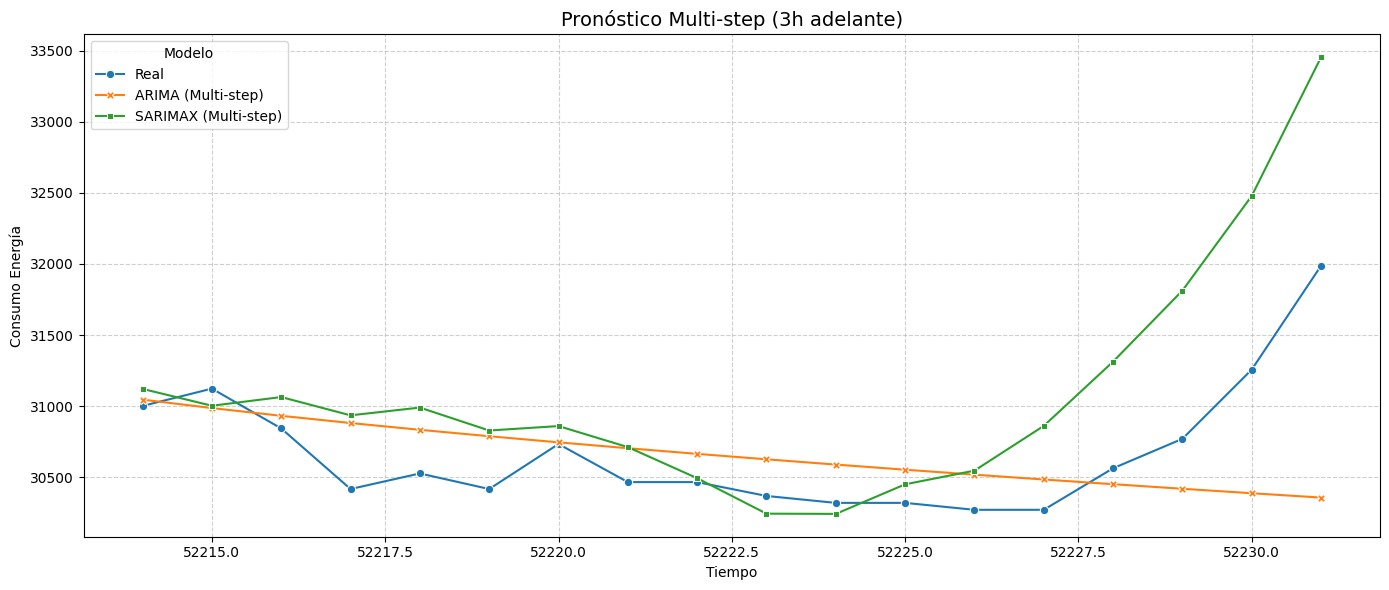

In [ ]:
# Armar dataframe con predicciones multi-step
df_multi = pd.DataFrame({
    "time": test_serie.index[:n_pasos_futuro],
    "Real": test_serie.iloc[:n_pasos_futuro].values,
    "ARIMA (Multi-step)": pred_arima_multi_mean.values,
    "SARIMAX (Multi-step)": pred_sarimax_multi_mean.values
})

df_multi_long = df_multi.melt(id_vars="time",
                              value_vars=["Real", "ARIMA (Multi-step)", "SARIMAX (Multi-step)"],
                              var_name="Modelo", value_name="Consumo")

# Gráfico con seaborn
plt.figure(figsize=(14,6))
sns.lineplot(data=df_multi_long, x="time", y="Consumo", hue="Modelo", style="Modelo", markers=True, dashes=False)

plt.title("Pronóstico Multi-step (3h adelante)", fontsize=14)
plt.xlabel("Tiempo")
plt.ylabel("Consumo Energía")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

En la predicción multi-step a 3 horas, se observa que al inicio de las predicciones SARIMAX sigue más de cerca el valor real en comparación con ARIMA, logrando captar mejor las fluctuaciones iniciales y reproduciendo con mayor realismo la trayectoria corta, mientras que ARIMA se mantiene excesivamente plano con una ligera tendencia descendente. En la parte media, cuando la serie real se sitúa en un nivel más bajo, SARIMAX coincide con el mínimo de la serie y continúa mostrando mayor ajuste, mientras que ARIMA conserva su tendencia lineal. Sin embargo, en los últimos pasos del horizonte, cuando la serie real comienza a repuntar, ARIMA termina subestimando los valores al no reconocer el cambio de tendencia, mientras que SARIMAX incurre en una sobrestimación notable, generando un crecimiento explosivo no observado en los datos reales. En conjunto, esto indica que SARIMAX ofrece mejor desempeño en horizontes cortos, capturando con mayor fidelidad los patrones inmediatos, aunque con riesgo de inestabilidad en horizontes más largos; en contraste, ARIMA es más estable y predecible en el largo plazo, pero menos sensible a cambios en la serie, lo cual lo hace conservador y plano frente a variaciones dinámicas.

TODO: Análisis de la gráfica

Métricas a evaluar:
1. sMAPE
2. WAPE

In [ ]:
# =====================================================
# TABLA 1: Pronóstico One-step Ahead
# =====================================================
resultados_1paso = []

# ARIMA - one-step
if pred_arima_one_step is not None:
    resultados_1paso.append({
        "Modelo": "ARIMA (One-step)",
        "Horizonte": "1 paso (10 min)",
        "sMAPE (%)": round(smape_arima_1step, 2),
        "WAPE (%)": round(wape_arima_1step, 2),
        "AIC": round(resultado_arima.aic, 2),
        "BIC": round(resultado_arima.bic, 2)
    })

# SARIMAX - one-step
if pred_sarimax_1 is not None:
    resultados_1paso.append({
        "Modelo": "SARIMAX (One-step)",
        "Horizonte": "1 paso (10 min)",
        "sMAPE (%)": round(smape_sarimax_1, 2),
        "WAPE (%)": round(wape_sarimax_1, 2),
        "AIC": round(resultado_sarimax.aic, 2),
        "BIC": round(resultado_sarimax.bic, 2)
    })

df_resultados_1paso = pd.DataFrame(resultados_1paso)
print("\nResultados Pronóstico One-step Ahead:")
print(df_resultados_1paso.to_string(index=False))


# =====================================================
# TABLA 2: Pronóstico Multi-step (3h adelante = 18 pasos)
# =====================================================
resultados_multi = []

# ARIMA - multi-step
if pred_arima_multi is not None:
    resultados_multi.append({
        "Modelo": "ARIMA (Multi-step)",
        "Horizonte": "3h adelante (18 pasos)",
        "sMAPE (%)": round(smape_arima_multi, 2),
        "WAPE (%)": round(wape_arima_multi, 2),
        "AIC": round(resultado_arima.aic, 2),
        "BIC": round(resultado_arima.bic, 2)
    })

# SARIMAX - multi-step
if pred_sarimax_multi is not None:
    resultados_multi.append({
        "Modelo": "SARIMAX (Multi-step)",
        "Horizonte": "3h adelante (18 pasos)",
        "sMAPE (%)": round(smape_sarimax_multi, 2),
        "WAPE (%)": round(wape_sarimax_multi, 2),
        "AIC": round(resultado_sarimax.aic, 2),
        "BIC": round(resultado_sarimax.bic, 2)
    })


df_resultados_multi = pd.DataFrame(resultados_multi)
print("\nResultados Pronóstico Multi-step (3h adelante):")
print(df_resultados_multi.to_string(index=False))


Resultados Pronóstico One-step Ahead:
            Modelo       Horizonte  sMAPE (%)  WAPE (%)      AIC      BIC
  ARIMA (One-step) 1 paso (10 min)      17.26     16.82 11801.44 11820.21
SARIMAX (One-step) 1 paso (10 min)       3.85      3.99  7351.02  7372.26

Resultados Pronóstico Multi-step (3h adelante):
              Modelo              Horizonte  sMAPE (%)  WAPE (%)      AIC      BIC
  ARIMA (Multi-step) 3h adelante (18 pasos)       1.09      1.09 11801.44 11820.21
SARIMAX (Multi-step) 3h adelante (18 pasos)       1.41      1.44  7351.02  7372.26


---

En el análisis comparativo de los modelos aplicados al pronóstico de consumo energético, se observa que el SARIMAX supera ampliamente al ARIMA en predicciones inmediatas (one-step ahead), obteniendo un sMAPE de 3.85% y un WAPE de 3.99%, frente a los 17.26% y 16.82% de ARIMA, lo que demuestra que la combinación de estacionalidad explícita y variable exógena (temperatura) permite capturar de manera mucho más fiel la dinámica de la demanda. Sin embargo, en el horizonte corto de predicción multi-step (3 horas adelante), ambos modelos presentan errores bajos, con un sMAPE de 1.09% para ARIMA y 1.41% para SARIMAX, siendo en este caso sorprendentemente más preciso ARIMA al suavizar mejor los valores de corto plazo, mientras que SARIMAX tiende a sobreajustar algunas oscilaciones. Respecto a los criterios de información, SARIMAX presenta AIC y BIC (7351 y 7372) muy inferiores a los de ARIMA (11801 y 11820), lo que indica un ajuste estadísticamente más sólido del modelo estacional con exógenas. No obstante, esta superioridad en capacidad predictiva y explicación de la serie implica un costo computacional considerable, ya que SARIMAX requirió alrededor de 1097 segundos (aproximadamente 18 minutos) de entrenamiento en Colab, mientras que ARIMA se entrenó en apenas 0.3 segundos. En conjunto, esto refleja un claro trade-off entre precisión y complejidad, donde SARIMAX es la mejor opción para aplicaciones donde la exactitud en la predicción es crítica (por ejemplo, planificación operativa de energía en tiempo real), mientras que ARIMA puede ser útil como modelo base ligero en escenarios que requieran reentrenamientos rápidos y frecuentes.

### REFERENCIAS:

Gianpiero Andrenacci. (2024, September 3). Predicting Time-Series with SARIMAX. Medium; AI Bistrot. https://medium.com/data-bistrot/predicting-time-series-with-sarimax-f805f6608cd2

‌gianpieroandrenacci. (2024, July 13). 📈 COVID-19 New Cases in Italy prediction (ARIMA). Kaggle.com; Kaggle. https://www.kaggle.com/code/gianpieroandrenacci/covid-19-new-cases-in-italy-prediction-arima?source=post_page-----f805f6608cd2---------------------------------------

‌